## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
#importing some useful packages
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

IMAGE_SHAPE = (720,1280,3)

CAL_IMAGES_DIR = "camera_cal/"
TEST_IMAGES_DIR = "test_images/"

CAL_NX = 9 # the number of inside corners in x
CAL_NY = 6 # the number of inside corners in y

def calibrate_camera(imgdir, nx, ny):
    
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    for filename in os.listdir(imgdir):
        # Read in an image
        img = cv2.imread(imgdir + filename)
    
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    height, width, _ = IMAGE_SHAPE
    
    # Use cv2.calibrateCamera() and cv2.undistort()
    print("Calibrating camera...")
    error, mtx, coefs, rvec, tvec = cv2.calibrateCamera(objpoints, imgpoints, (width, height) , None, None)
    print("Reprojection error: {:6f}".format(error))   
    
    return mtx, coefs


mtx, dist = calibrate_camera(CAL_IMAGES_DIR, CAL_NX, CAL_NY)

Calibrating camera...
Reprojection error: 1.186897


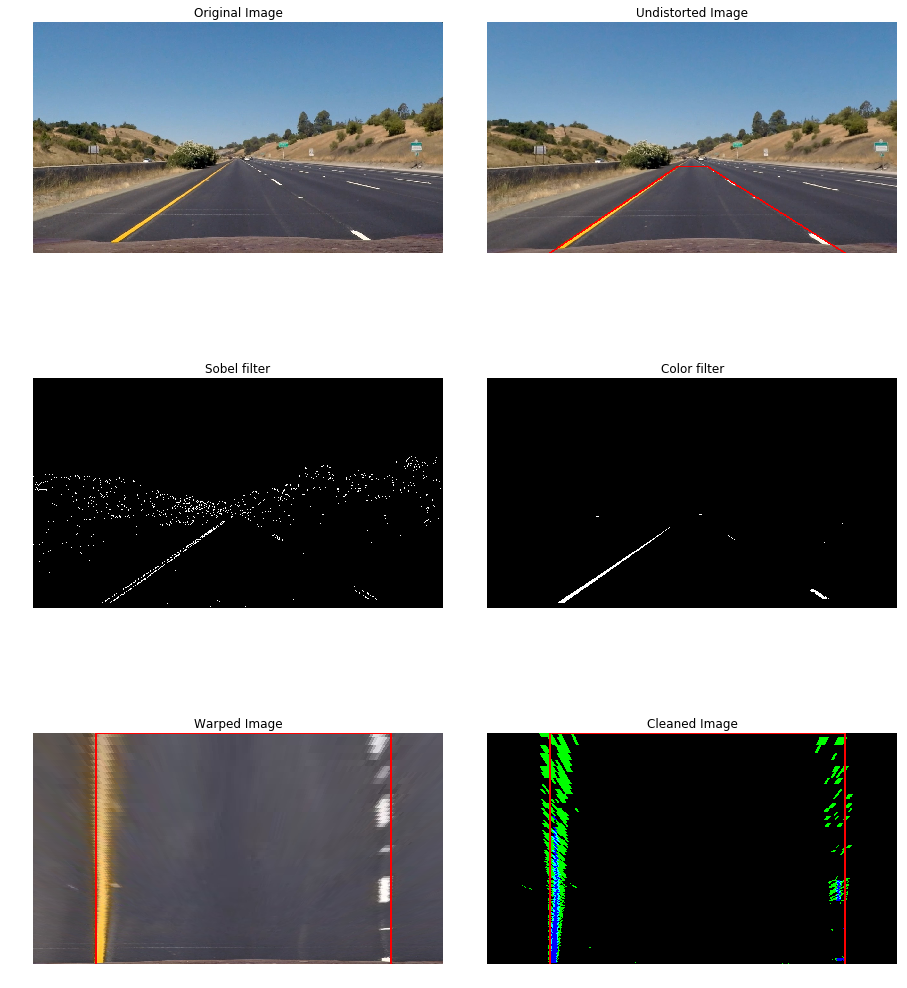

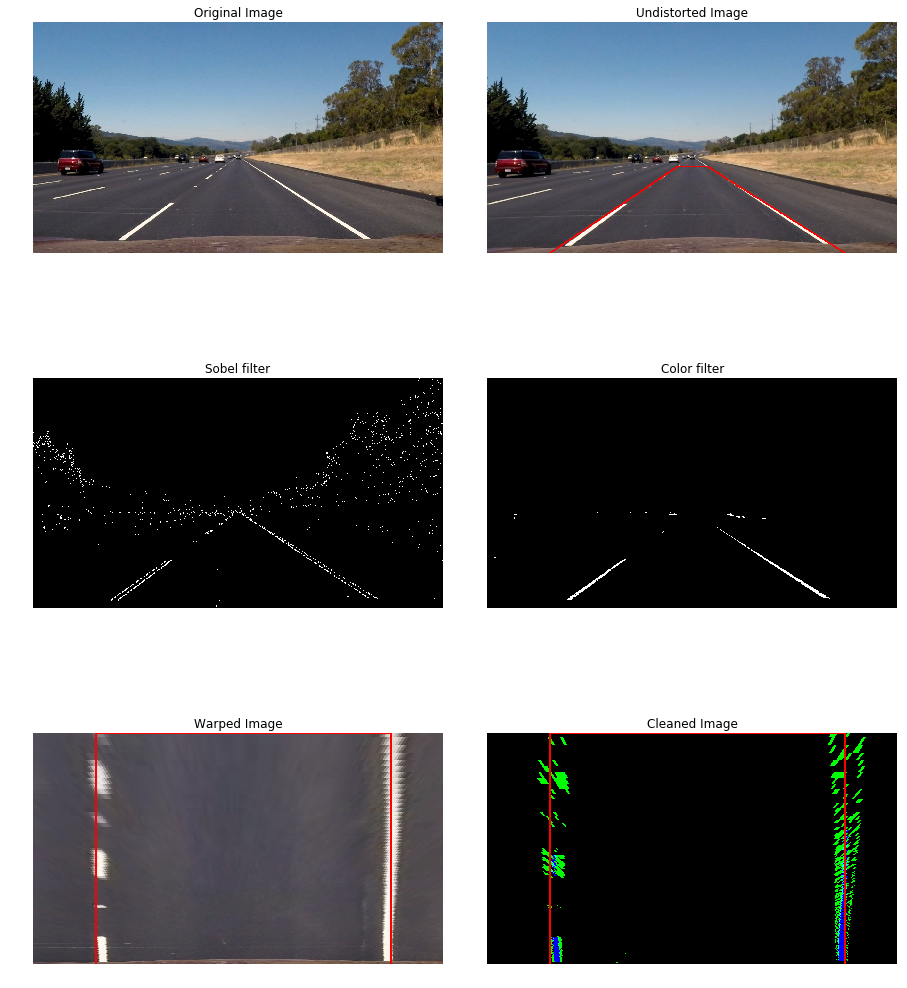

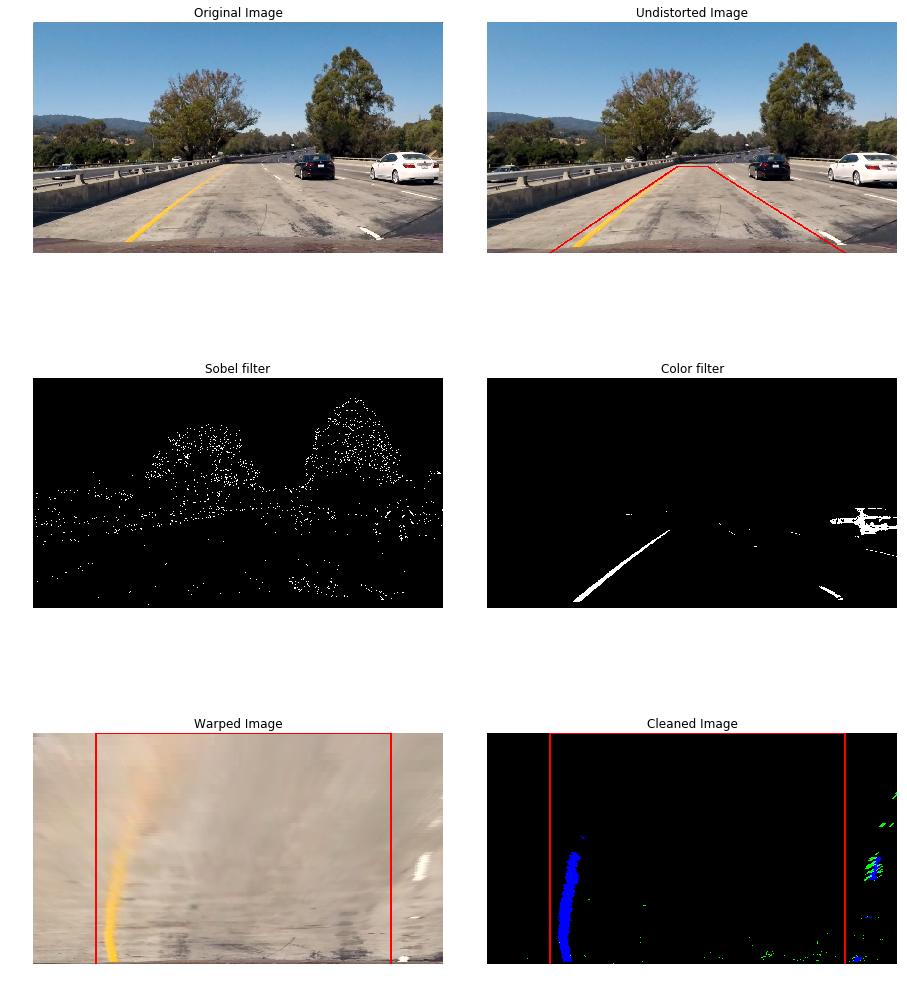

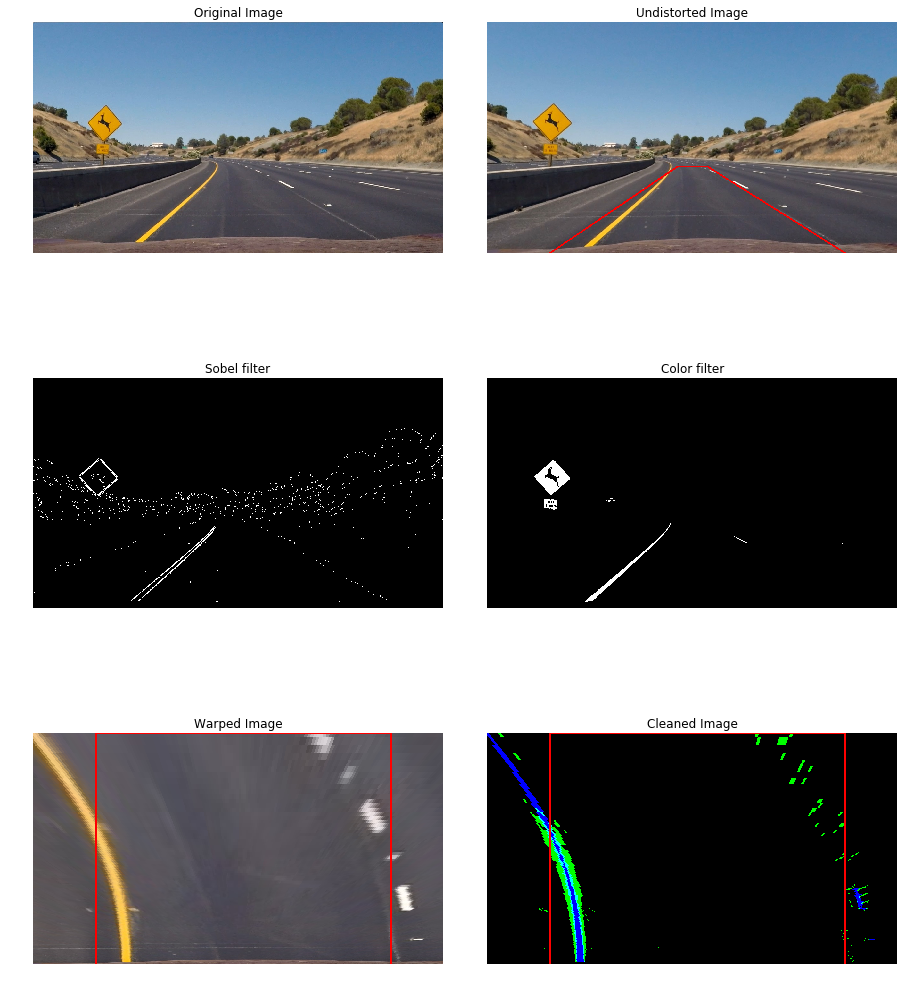

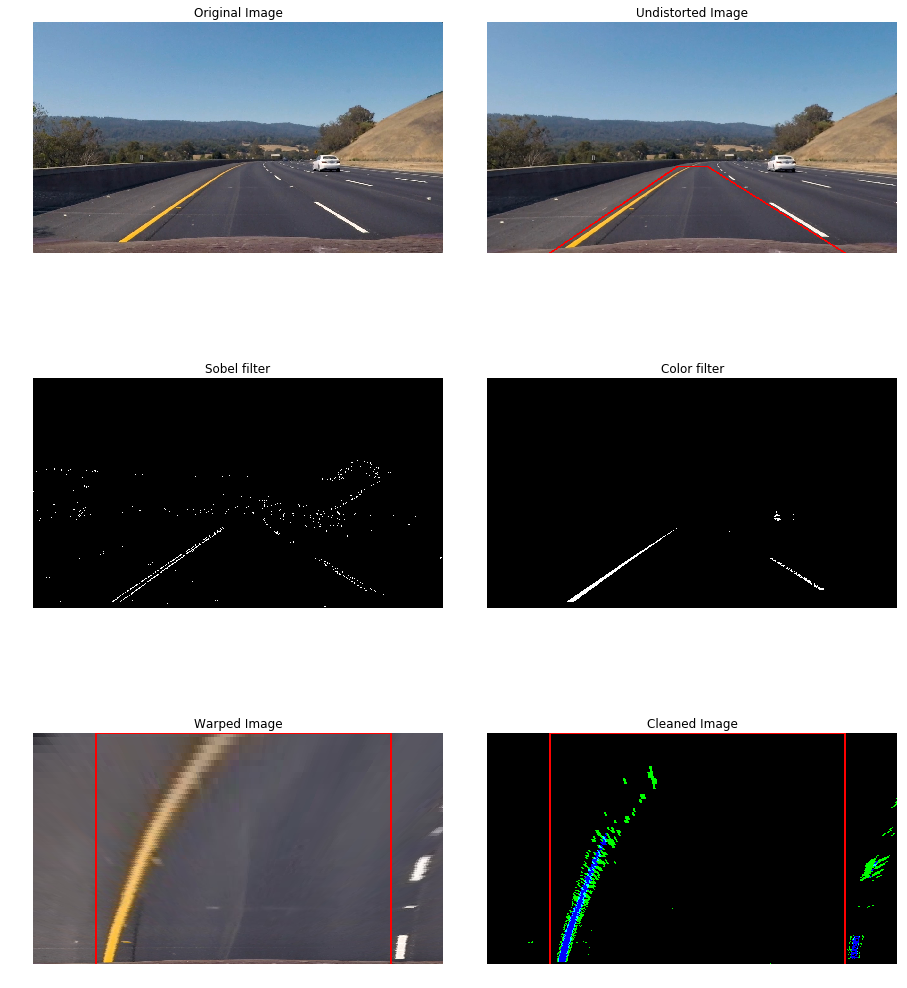

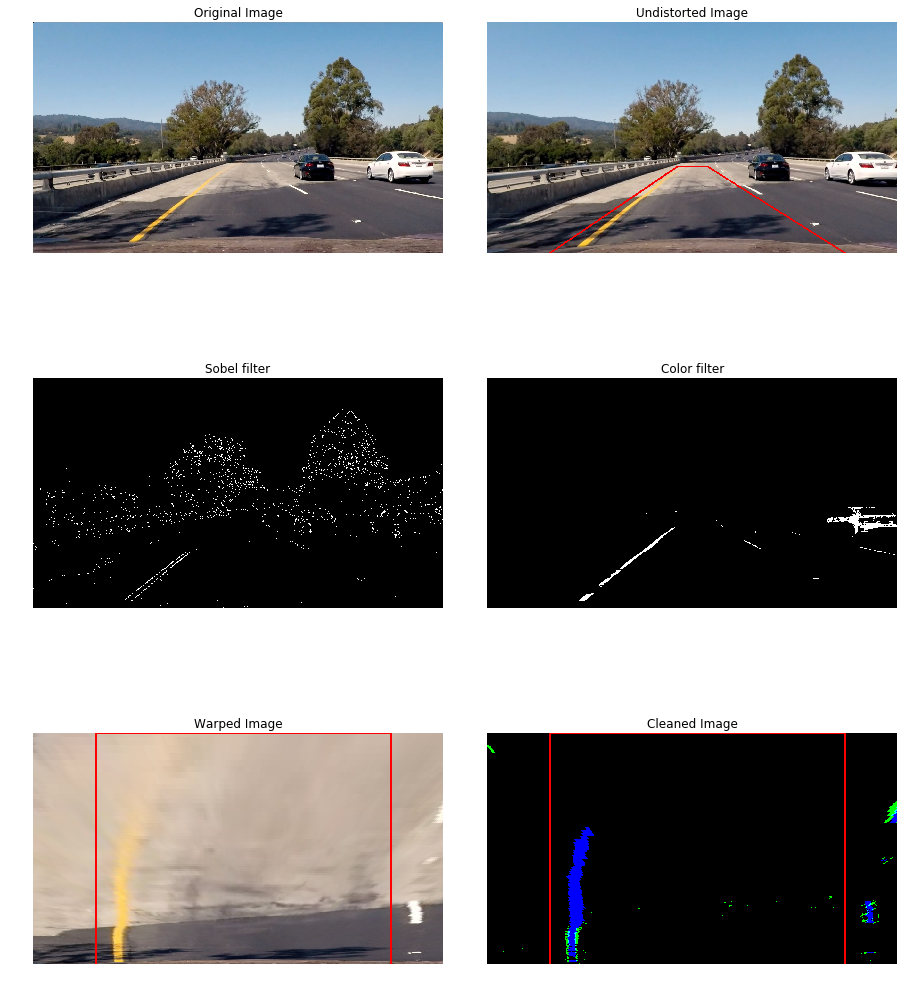

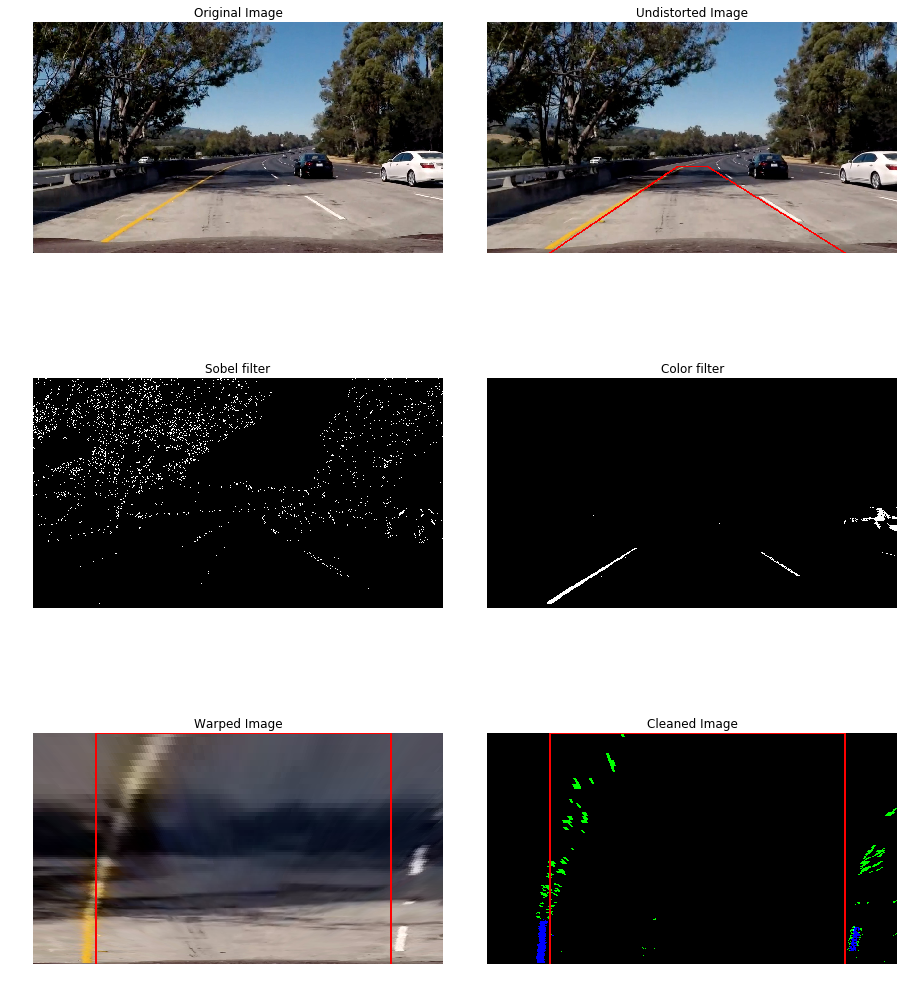

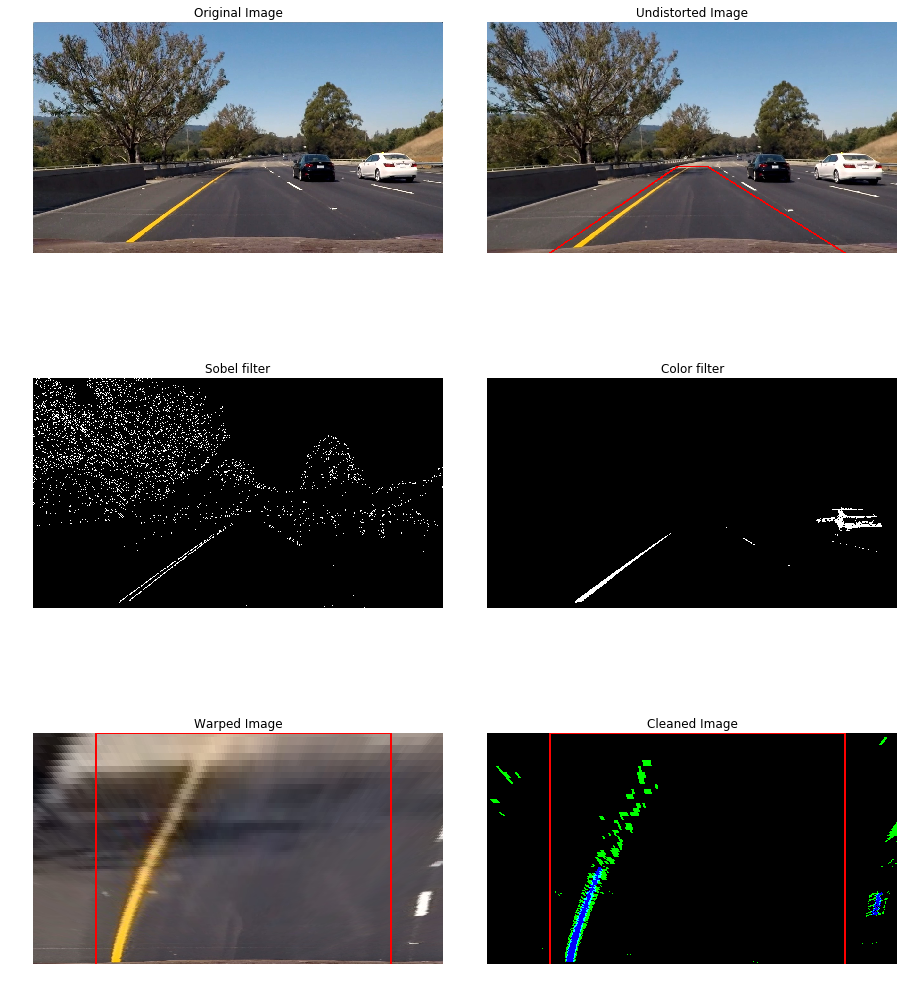

In [147]:
def undistort_image(img, mtx, dist):   
    return cv2.undistort(img, mtx, dist, None, mtx)

def sobel_threshold(img, mag_thresh, dir_thresh, kernel_size=5):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    sobel_mag = np.hypot(sobel_x, sobel_y)
    sobel_mag = np.uint8(sobel_mag * 255 / np.max(sobel_mag))
    sobel_dir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    
    binary_output = np.zeros_like(gray)    
    binary_output[(sobel_mag >= mag_thresh[0]) & (sobel_mag <= mag_thresh[1]) &
                  (sobel_dir >= dir_thresh[0]) & (sobel_dir <= dir_thresh[1])] = 255
    
    return binary_output

def color_threshold(img, h_thresh=(0,255), l_thresh=(0,255), s_thresh=(0,255)):
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls_img[:,:,0]
    l_channel = hls_img[:,:,1]
    s_channel = hls_img[:,:,2]
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1]) &
                  (l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1]) &
                  (s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 255
    return binary_output

def warp_image(img, src, dst):
    h, w, _ = img.shape
    M = cv2.getPerspectiveTransform(np.float32(src), dst)
    warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_NEAREST+cv2.WARP_FILL_OUTLIERS)
    return warped

ksize = 3
mag_thresh = (30, 255)
dir_thresh = (0.55, 1.0)
h_thresh = (0,255)
l_thresh = (100,255)
s_thresh = (170,255)

height, width, _ = IMAGE_SHAPE

apex_left = (width / 2 - 46, height / 2 + 90)
apex_right =(width / 2 + 48, height / 2 + 90)
base_left = (196, height)
base_right = (width - 162, height)
    
vertices = np.float32([[base_left, apex_left, apex_right, base_right]])
warped_vertices = np.float32([[base_left, [base_left[0], 0], [base_right[0], 0], base_right]])

for filename in os.listdir(TEST_IMAGES_DIR):
    image = mpimg.imread(TEST_IMAGES_DIR + filename)

    undistorted = undistort_image(image, mtx, dist)
    
    lregion = np.copy(undistorted);
    cv2.polylines(lregion, np.int32(vertices), 0, [255,0,0], 4)

    binary_sobel = sobel_threshold(undistorted, mag_thresh, dir_thresh, kernel_size=ksize)
    binary_color = color_threshold(undistorted, h_thresh, l_thresh, s_thresh)

    warped = warp_image(undistorted, vertices, warped_vertices)
    cv2.polylines(warped, np.int32(warped_vertices), 0, [255,0,0], 4)
    
    cleaned = np.dstack((np.zeros_like(binary_color), binary_sobel, binary_color))
    cleaned = warp_image(cleaned, vertices, warped_vertices)
    cv2.polylines(cleaned, np.int32(warped_vertices), 0, [255,0,0], 4)
    
    fig, ax = plt.subplots(3, 2, figsize=(12,16))
    fig.tight_layout()
    ax[0][0].imshow(image)
    ax[0][0].set_title('Original Image')
    ax[0][0].set_axis_off()
    ax[0][1].imshow(lregion)
    ax[0][1].set_title('Undistorted Image')
    ax[0][1].set_axis_off()
    ax[1][0].imshow(binary_sobel, cmap='gray')
    ax[1][0].set_title('Sobel filter')
    ax[1][0].set_axis_off()
    ax[1][1].imshow(binary_color, cmap='gray')
    ax[1][1].set_title('Color filter')
    ax[1][1].set_axis_off()
    ax[2][0].imshow(warped)
    ax[2][0].set_title('Warped Image')
    ax[2][0].set_axis_off()
    ax[2][1].imshow(cleaned)
    ax[2][1].set_title('Cleaned Image')
    ax[2][1].set_axis_off()
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
    plt.show()